# PyUnfold Tutorial : Extra Features

This tutorial presents some unfolding examples using additional PyUnfold features.

Most notably these include:
- implementing a user-defined prior
- smoothing via spline regularization
- demonstrating the multivariate capabilities using cause groups
- potential pitfalls in using advanced tools

But first lets set up the data.

In [1]:
from pyunfold import iterative_unfold
from pyunfold.callbacks import Logger

/Users/zhampel/py-venv/python3/lib/python3.6/site-packages/matplotlib/__init__.py:908: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)
/Users/zhampel/py-venv/python3/lib/python3.6/site-packages/matplotlib/__init__.py:908: MatplotlibDeprecationWarning: The backend.qt4 rcParam was deprecated in version 2.2.  In order to force the use of a specific Qt binding, either import that binding first, or set the QT_API environment variable.
  mplDeprecation)


In [2]:
import numpy as np
import matplotlib.pyplot as plt 
np.random.seed(2)
%matplotlib inline

## True and Observed Distributions

We'll generate some data with the same distributions as in the main tutorial, i.e. a Gaussian sample that is smeared by some noise.

In [3]:
# True distribution
num_samples = int(1e5)
true_samples = np.random.normal(loc=0.0, scale=1.0, size=num_samples)
bins = np.linspace(-3, 3, 21)
data_true, _ = np.histogram(true_samples, bins=bins)

# Observed distribution
random_noise = np.random.normal(loc=0.3, scale=0.5, size=num_samples)
observed_samples = true_samples + random_noise
data_observed, _ = np.histogram(observed_samples, bins=bins)
data_observed_err = np.sqrt(data_observed)

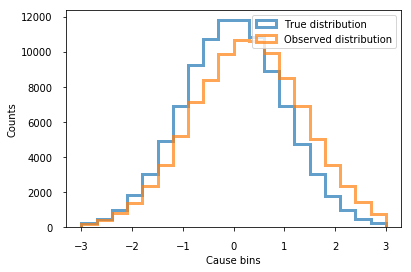

In [4]:
plt.hist(true_samples, bins=bins, histtype='step', lw=3,
         alpha=0.7, label='True distribution')
plt.hist(observed_samples, bins=bins, histtype='step', lw=3,
         alpha=0.7, label='Observed distribution')
plt.xlabel('Cause bins')
plt.ylabel('Counts')
plt.legend()
plt.show()

## Response Function

We'll keep our detection efficiency at 1 for all cause bins for now, again keeping the same response matrix as before.

In [5]:
# Efficiencies
efficiencies = np.ones_like(data_observed, dtype=float)
efficiencies_err = np.full_like(efficiencies, 0.1, dtype=float)

# Response matrix
response_hist, _, _ = np.histogram2d(observed_samples, true_samples, bins=bins)
response_hist_err = np.sqrt(response_hist)

# Scale by efficiency
column_sums = response_hist.sum(axis=0)
normalization_factor = efficiencies / column_sums

response = response_hist * normalization_factor
response_err = response_hist_err * normalization_factor

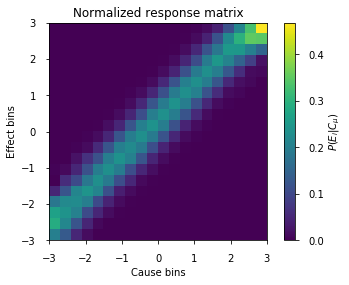

In [6]:
plt.imshow(response,
           origin='lower', 
           extent=[bins.min(), bins.max(), bins.min(), bins.max()])
plt.colorbar(label='$P(E_i|C_{\mu})$')
plt.xlabel('Cause bins')
plt.ylabel('Effect bins')
plt.title('Normalized response matrix')
plt.show()

## Custom Priors

The default initial prior is the uniform distribution.
We can test other priors by providing a normalized distribution via the `prior` keyword
in the `iterative_unfold` function.

One such custom prior is the non-informative Jeffreys' prior.
So far we have made no mention of the nature of the causes, simply assigning them bins.
To use the Jeffreys' prior (via the `jeffreys_prior` function), we'll need the cause range.
Here we assume that the cause range covers three orders of magnitude, $C_{\mu} \in [1, 10^3]$.

In [7]:
from pyunfold.priors import jeffreys_prior, uniform_prior

# Cause limits
num_causes = len(efficiencies)
cause_lim = np.logspace(0, 3, num_causes)

# Uniform and Jeffreys' priors
uni_prior = uniform_prior(num_causes)
jeff_prior = jeffreys_prior(cause_lim)

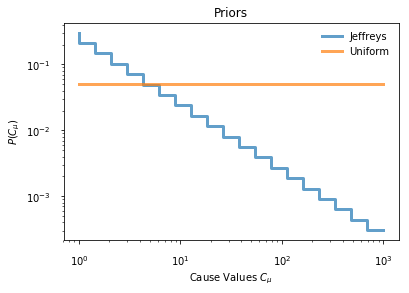

In [8]:
plt.step(cause_lim, jeff_prior, lw=3,
         alpha=0.7, label='Jeffreys')
plt.step(cause_lim, uni_prior, lw=3,
         alpha=0.7, label='Uniform')
plt.title('Priors')
plt.xlabel(r'Cause Values $C_{\mu}$')
plt.ylabel(r'$P(C_{\mu})$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='upper right', frameon=False)
plt.show()

## Unfold

Now we can run the unfolding with the Jeffreys' prior and compare to the default as well as the true cause distribution.

In [9]:
print("Running with uniform prior...")
unfolded_results_uni = iterative_unfold(data=data_observed,
                                        data_err=data_observed_err,
                                        response=response,
                                        response_err=response_err,
                                        efficiencies=efficiencies,
                                        efficiencies_err=efficiencies_err,
                                        ts='ks',
                                        ts_stopping=0.01,
                                        callbacks=[Logger()])

print('\n')
print("Running with Jeffreys' prior...")
unfolded_results_jeff = iterative_unfold(data=data_observed,
                                        data_err=data_observed_err,
                                        response=response,
                                        response_err=response_err,
                                        efficiencies=efficiencies,
                                        efficiencies_err=efficiencies_err,
                                        prior=jeff_prior,
                                        ts='ks',
                                        ts_stopping=0.01,
                                        callbacks=[Logger()])

Running with uniform prior...
Iteration 1: ts = 0.1405, ts_stopping = 0.01
Iteration 2: ts = 0.0370, ts_stopping = 0.01
Iteration 3: ts = 0.0122, ts_stopping = 0.01
Iteration 4: ts = 0.0045, ts_stopping = 0.01


Running with Jeffreys' prior...
Iteration 1: ts = 0.6671, ts_stopping = 0.01
Iteration 2: ts = 0.1089, ts_stopping = 0.01
Iteration 3: ts = 0.0219, ts_stopping = 0.01
Iteration 4: ts = 0.0059, ts_stopping = 0.01


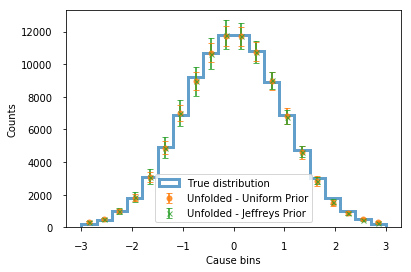

In [10]:
bin_midpoints = (bins[1:] + bins[:-1]) / 2
plt.hist(true_samples, bins=bins, histtype='step', lw=3,
         alpha=0.7,
         label='True distribution')

plt.errorbar(bin_midpoints, unfolded_results_uni['unfolded'],
             yerr=unfolded_results_uni['sys_err'],
             alpha=0.8,
             elinewidth=2,
             capsize=3,
             ls='None', marker='o', ms=5, 
             label='Unfolded - Uniform Prior')

plt.errorbar(bin_midpoints, unfolded_results_jeff['unfolded'],
             yerr=unfolded_results_jeff['sys_err'],
             alpha=0.8,
             elinewidth=2,
             capsize=3,
             ls='None', marker='x', ms=5, 
             label='Unfolded - Jeffreys Prior')

plt.xlabel('Cause bins')
plt.ylabel('Counts')
plt.legend(loc='best', frameon=True)
plt.show()

The unfolded distributions are consistent with each other as well as with the true distribution!
Thus, our results are robust with respect to these two **smooth** initial priors.

In many experimental setups, we expect the true cause distribution to be fairly smooth.
What if we try some bumpy, potentially *non-physical* prior?

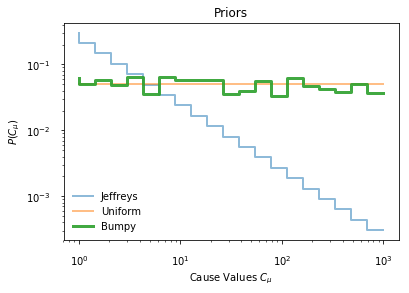

In [18]:
# Bumpy random prior
bumpy_prior = np.abs(np.random.normal(loc=1, scale=0.35, size=num_causes))
bumpy_prior /= bumpy_prior.sum()

plt.step(cause_lim, jeff_prior, lw=2,
         alpha=0.5, label='Jeffreys')
plt.step(cause_lim, uni_prior, lw=2,
         alpha=0.5, label='Uniform')
plt.step(cause_lim, bumpy_prior, lw=3,
         alpha=0.9, label='Bumpy')
plt.title('Priors')
plt.xlabel(r'Cause Values $C_{\mu}$')
plt.ylabel(r'$P(C_{\mu})$')
plt.xscale('log')
plt.yscale('log')
plt.legend(loc='lower left', frameon=False)
plt.show()

In [19]:
print("Running with bumpy prior...")
unfolded_results_bumpy = iterative_unfold(data=data_observed,
                                          data_err=data_observed_err,
                                          response=response,
                                          response_err=response_err,
                                          efficiencies=efficiencies,
                                          efficiencies_err=efficiencies_err,
                                          prior=bumpy_prior,
                                          ts='ks',
                                          ts_stopping=0.01,
                                          callbacks=[Logger()])

Running with bumpy prior...
Iteration 1: ts = 0.1655, ts_stopping = 0.01
Iteration 2: ts = 0.0360, ts_stopping = 0.01
Iteration 3: ts = 0.0133, ts_stopping = 0.01
Iteration 4: ts = 0.0056, ts_stopping = 0.01


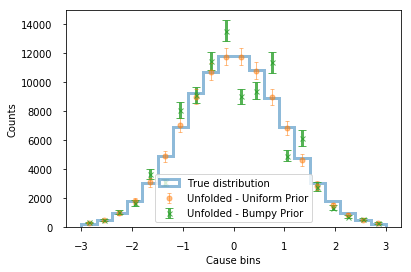

In [20]:
bin_midpoints = (bins[1:] + bins[:-1]) / 2
plt.hist(true_samples, bins=bins, histtype='step', lw=3,
         alpha=0.5,
         label='True distribution')

plt.errorbar(bin_midpoints, unfolded_results_uni['unfolded'],
             yerr=unfolded_results_uni['sys_err'],
             alpha=0.5,
             elinewidth=1,
             capsize=2,
             ls='None', marker='o', ms=5, 
             label='Unfolded - Uniform Prior')

plt.errorbar(bin_midpoints, unfolded_results_bumpy['unfolded'],
             yerr=unfolded_results_bumpy['sys_err'],
             alpha=0.8,
             elinewidth=3,
             capsize=4,
             ls='None', marker='x', ms=5, 
             label='Unfolded - Bumpy Prior')

plt.xlabel('Cause bins')
plt.ylabel('Counts')
plt.legend(loc='best', frameon=True)
plt.show()

Clearly, the non-smooth initial prior has a **strong** influence on the unfolded spectrum. 
This is one potential pitfall: the initial prior *informs* the procedure as to what properties we think the true distribution has. Unlike for the uniform and Jeffreys cases, the bumpy prior tells the unfolder that the true distribution may be bumpy, so the results are also bumpy.

## Regularization

We can try to ameliorate this bumpiness by smoothing or regularizing during the unfolding procedure.
Here, we can tune the univariate `SplineRegularizer` routine accessible from the `pyunfold.callbacks`.

In [21]:
from pyunfold.callbacks import SplineRegularizer
degree = 3
smooth = 5e6
spline_reg = SplineRegularizer(degree=degree, smooth=smooth)

In [22]:
unfolded_results_bumpy_reg = iterative_unfold(data=data_observed,
                                              data_err=data_observed_err,
                                              response=response,
                                              response_err=response_err,
                                              efficiencies=efficiencies,
                                              efficiencies_err=efficiencies_err,
                                              prior=bumpy_prior,
                                              ts='ks',
                                              ts_stopping=0.01,
                                              callbacks=[Logger(), spline_reg])

Iteration 1: ts = 0.1686, ts_stopping = 0.01
Iteration 2: ts = 0.0400, ts_stopping = 0.01
Iteration 3: ts = 0.0158, ts_stopping = 0.01
Iteration 4: ts = 0.0112, ts_stopping = 0.01
Iteration 5: ts = 0.0078, ts_stopping = 0.01


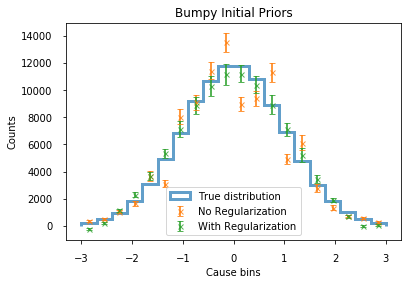

In [23]:
bin_midpoints = (bins[1:] + bins[:-1]) / 2
plt.hist(true_samples, bins=bins, histtype='step', lw=3,
         alpha=0.7,
         label='True distribution')

plt.errorbar(bin_midpoints, unfolded_results_bumpy['unfolded'],
             yerr=unfolded_results_bumpy['sys_err'],
             alpha=0.8,
             elinewidth=2,
             capsize=3,
             ls='None', marker='x', ms=5, 
             label='No Regularization')

plt.errorbar(bin_midpoints, unfolded_results_bumpy_reg['unfolded'],
             yerr=unfolded_results_bumpy_reg['sys_err'],
             alpha=0.8,
             elinewidth=2,
             capsize=3,
             ls='None', marker='x', ms=5, 
             label='With Regularization')

plt.title('Bumpy Initial Priors')
plt.xlabel('Cause bins')
plt.ylabel('Counts')
plt.legend(loc='best', frameon=True)
plt.show()

The regularized unfolded result is indeed more consistent with the true distribution, but at the cost of taking a couple of extra iterations to converge, and thus has slightly larger uncertainties due to more mixing.

For this example, a strong regularization parameter (`smooth = 5e6`) was needed to return consistent unfolded results. Assuming a smooth initial prior is the proper way to avoid this potential issue, unless one does indeed have overriding assumptions regarding smoothness.

## Cause Groups

As a final demonstration of advanced capabilities in PyUnfold, we present the generalization to multivariate unfolding.

To illustrate this idea, we consider a set of effects originating from two different **cause types** having their own ranges. We can assign a new superscript $i$ to denote these types: 

$$
C_{\mu}^{i} \text{ where } i \in [1,2]
$$

and the subscript $\mu$ runs over the respective number of causes in each type $\, n_{C1}$ and $\, n_{C2}$.

But since the PyUnfold doesn't care how we label the bins, we can simply redefine our cause index $\mu$ to run over a larger index range. Hence, 

$$
C_{\mu}^i \rightarrow C_{\mu} \text{ where } \mu \in [1, \, n_{C1} + n_{C2}]
$$

Thus, given a general multidimensional ($i>1$) response matrix, we can effectively *unroll* it onto a two dimensional array and still use PyUnfold.

### Example

It's probably easier to use a visual example. Here we use two identical cause groups, simply copying our response matrix along the cause axis.

In [24]:
# Response with two groups
response_hist_groups = np.concatenate((response_hist, response_hist), axis=1)
response_hist_groups_err = np.sqrt(response_hist_groups)

# Efficiencies with two groups
efficiencies_groups = np.ones(response_hist_groups.shape[1], dtype=float)
efficiencies_groups_err = np.full_like(efficiencies_groups, 0.1, dtype=float)

# Scale by efficiency
column_sums_groups = response_hist_groups.sum(axis=0)
normalization_factor_groups = efficiencies_groups / column_sums_groups

# Response matrix with two groups
response_groups = response_hist_groups * normalization_factor_groups
response_groups_err = response_hist_groups_err * normalization_factor_groups

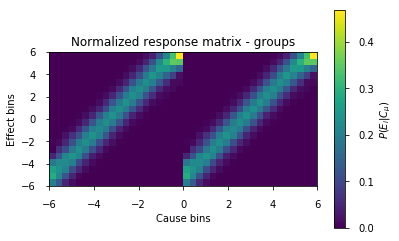

In [25]:
plt.imshow(response_groups,
           origin='lower',
           aspect='0.5',
           extent=[2*bins.min(), 2*bins.max(), 2*bins.min(), 2*bins.max()])
plt.colorbar(label='$P(E_i|C_{\mu})$')
plt.xlabel('Cause bins')
plt.ylabel('Effect bins')
plt.title('Normalized response matrix - groups')
plt.show()

Now the two (identical) cause groups are *unrolled* clearly along the abscissa. Since the unfolding method is cause agnostic, we can perform an unfolding, remembering that we've kept the same observed data.

Iteration 1: ts = 0.0702, ts_stopping = 0.01
Iteration 2: ts = 0.0185, ts_stopping = 0.01
Iteration 3: ts = 0.0061, ts_stopping = 0.01


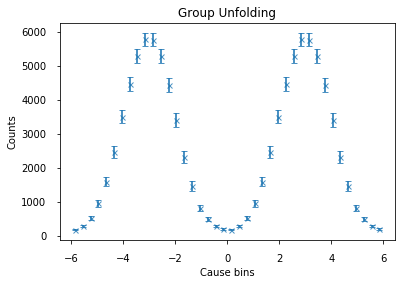

In [26]:
unfolded_results_groups = iterative_unfold(data=data_observed,
                                           data_err=data_observed_err,
                                           response=response_groups,
                                           response_err=response_groups_err,
                                           efficiencies=efficiencies_groups,
                                           efficiencies_err=efficiencies_groups_err,
                                           ts='ks',
                                           ts_stopping=0.01,
                                           callbacks=[Logger()])

# Extend range of bins
bin_groups = np.linspace(-6, 6, 41)
bin_midpoints_groups = (bin_groups[1:] + bin_groups[:-1]) / 2

plt.errorbar(bin_midpoints_groups, unfolded_results_groups['unfolded'],
             yerr=unfolded_results_groups['sys_err'],
             alpha=0.8,
             elinewidth=2,
             capsize=3,
             ls='None', marker='x', ms=5)

plt.title('Group Unfolding')
plt.xlabel('Cause bins')
plt.ylabel('Counts')
#plt.legend(loc='best', frameon=True)
plt.show()

So the result is two equal copies of the causes. This makes sense because in our example we have simply considered two *identical* groups of causes, so they should contribute identically to producing the measured effects.

### User Priors with Groups

What if we want to use the Jeffreys' prior? In this case, we have to setup the `prior` input to contain the priors we want for each group.

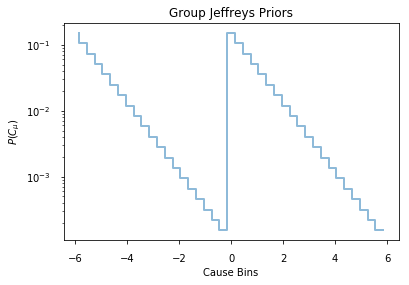

In [27]:
# Setup group Jeffreys' prior
prior_jeff_groups = np.concatenate([jeffreys_prior(cause_lim), jeffreys_prior(cause_lim)])
prior_jeff_groups /= prior_jeff_groups.sum()

plt.step(bin_midpoints_groups, prior_jeff_groups, lw=2,
         alpha=0.5)
plt.title('Group Jeffreys Priors')
plt.xlabel(r'Cause Bins')
plt.ylabel(r'$P(C_{\mu})$')
plt.yscale('log')
plt.show()

Iteration 1: ts = 0.3336, ts_stopping = 0.01
Iteration 2: ts = 0.0545, ts_stopping = 0.01
Iteration 3: ts = 0.0109, ts_stopping = 0.01
Iteration 4: ts = 0.0030, ts_stopping = 0.01


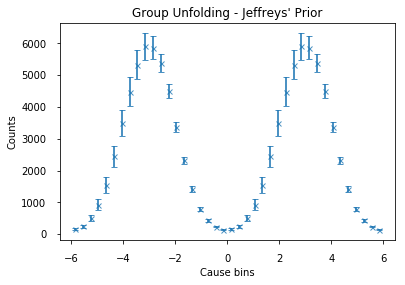

In [28]:
unfolded_results_groups_jeff = iterative_unfold(data=data_observed,
                                                data_err=data_observed_err,
                                                response=response_groups,
                                                response_err=response_groups_err,
                                                efficiencies=efficiencies_groups,
                                                efficiencies_err=efficiencies_groups_err,
                                                prior=prior_jeff_groups,
                                                ts='ks',
                                                ts_stopping=0.01,
                                                callbacks=[Logger()])

plt.errorbar(bin_midpoints_groups, unfolded_results_groups_jeff['unfolded'],
             yerr=unfolded_results_groups_jeff['sys_err'],
             alpha=0.8,
             elinewidth=2,
             capsize=3,
             ls='None', marker='x', ms=5)

plt.title("Group Unfolding - Jeffreys' Prior")
plt.xlabel('Cause bins')
plt.ylabel('Counts')
plt.show()

Again, we recover two copies of the causes.

### Regularization with Groups

In general, groups of causes do not share continuity of the cause axis. 
In the above examples, the cause arrays are stacked next to each other, so while the unfolding method doesn't care about the cause definitions, the default regularization smooths over **all** cause bins without regard to types.

PyUnfold implements group regularization, where smoothing of the unfolded distributions is performed only within designated cause types.
This is done by providing the `SplineRegularizer` function a `groups` list, defining the corresponding group numbers for each cause bin.

In [29]:
degree = 4
smooth = 10

# Here we know we have two copies of the causes
n_c1 = int(response_groups.shape[1]/2)
n_c2 = int(response_groups.shape[1]/2)

groups = [0]*n_c1 + [1]*n_c2
print("Group definitions: {}".format(groups))

group_reg = SplineRegularizer(degree=3, smooth=1.25, groups=groups)

Group definitions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [30]:
unfolded_results_groups_reg = iterative_unfold(data=data_observed,
                                               data_err=data_observed_err,
                                               response=response_groups,
                                               response_err=response_groups_err,
                                               efficiencies=efficiencies_groups,
                                               efficiencies_err=efficiencies_groups_err,
                                               ts='ks',
                                               ts_stopping=0.01,
                                               callbacks=[Logger(), group_reg])

Iteration 1: ts = 0.0702, ts_stopping = 0.01
Iteration 2: ts = 0.0185, ts_stopping = 0.01
Iteration 3: ts = 0.0061, ts_stopping = 0.01


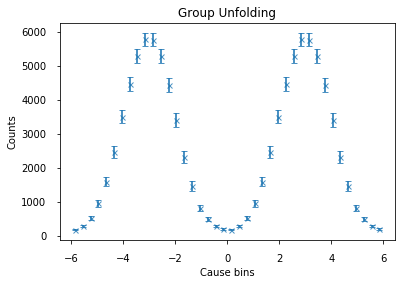

In [31]:
plt.errorbar(bin_midpoints_groups, unfolded_results_groups_reg['unfolded'],
             yerr=unfolded_results_groups_reg['sys_err'],
             alpha=0.8,
             elinewidth=2,
             capsize=3,
             ls='None', marker='x', ms=5)

plt.title('Group Unfolding')
plt.xlabel('Cause bins')
plt.ylabel('Counts')
plt.show()

Again, for this simple examle, everything looks fine.

However, if we consider a more complicated example, we'll see the power of these implementations.

Let's generate some more fake data by keeping our two-type response matrix.

In [32]:
# True distribution
group_data_true = np.concatenate((np.linspace(10, 100, n_c1), np.linspace(1, 10, n_c2)))
# Observed data, no smearing
group_data_observed = response_groups.dot(group_data_true)
group_data_observed_err = np.sqrt(group_data_observed)

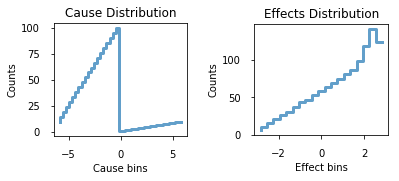

In [33]:
plt.subplot(1, 2, 1, aspect=0.1)
plt.step(bin_midpoints_groups, group_data_true, lw=3,
         alpha=0.7, label='True distribution')
plt.title('Cause Distribution')
plt.xlabel('Cause bins')
plt.ylabel('Counts')

plt.subplot(1, 2, 2, aspect=0.035)
plt.step(bin_midpoints, group_data_observed, lw=3,
         alpha=0.7, label='Observed distribution')
plt.title('Effects Distribution')
plt.xlabel('Effect bins')
plt.ylabel('Counts')
plt.subplots_adjust(wspace = .5)
plt.show()

In [34]:
# Setup all cause spline
degree = 3
smooth = 5e6
spline_reg = SplineRegularizer(degree=degree, smooth=smooth)

# Setup group spline
degree = 3
smooth = 10
group_reg = SplineRegularizer(degree=3, smooth=1.25, groups=groups)

In [35]:
unfolded_results_groups_default_reg = iterative_unfold(data=group_data_observed,
                                                       data_err=group_data_observed_err,
                                                       response=response_groups,
                                                       response_err=response_groups_err,
                                                       efficiencies=efficiencies_groups,
                                                       efficiencies_err=efficiencies_groups_err,
                                                       ts='ks',
                                                       ts_stopping=0.01,
                                                       callbacks=[Logger(), spline_reg])

Iteration 1: ts = 0.0857, ts_stopping = 0.01
Iteration 2: ts = 0.0496, ts_stopping = 0.01
Iteration 3: ts = 0.0279, ts_stopping = 0.01
Iteration 4: ts = 0.0154, ts_stopping = 0.01
Iteration 5: ts = 0.0084, ts_stopping = 0.01


In [36]:
unfolded_results_groups_group_reg = iterative_unfold(data=group_data_observed,
                                                     data_err=group_data_observed_err,
                                                     response=response_groups,
                                                     response_err=response_groups_err,
                                                     efficiencies=efficiencies_groups,
                                                     efficiencies_err=efficiencies_groups_err,
                                                     ts='ks',
                                                     ts_stopping=0.01,
                                                     callbacks=[Logger(), group_reg])

Iteration 1: ts = 0.1016, ts_stopping = 0.01
Iteration 2: ts = 0.0067, ts_stopping = 0.01


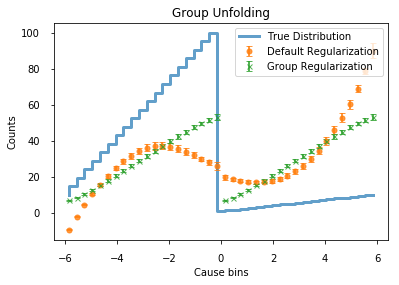

In [37]:
plt.step(bin_midpoints_groups, group_data_true, lw=3,
         alpha=0.7, label='True Distribution')

plt.errorbar(bin_midpoints_groups, unfolded_results_groups_default_reg['unfolded'],
             yerr=unfolded_results_groups_default_reg['sys_err'],
             alpha=0.8,
             elinewidth=2,
             capsize=3,
             ls='None', marker='o', ms=5,
             label='Default Regularization')

plt.errorbar(bin_midpoints_groups, unfolded_results_groups_group_reg['unfolded'],
             yerr=unfolded_results_groups_group_reg['sys_err'],
             alpha=0.8,
             elinewidth=2,
             capsize=3,
             ls='None', marker='x', ms=5,
             label='Group Regularization')

plt.title('Group Unfolding')
plt.xlabel('Cause bins')
plt.ylabel('Counts')
plt.legend(loc='best', frameon=True)
plt.show()

Whoa, what's going on here?

So there are actually two problems here. 

1. It's clear that the default regularization tries to connect the two cause groups in a smooth manner.
2. And while the group regularization is doing its best to smooth each group individually, it's clear we are getting copies again. This is due to the **prior** assumption that all causes have equal probabilities.

Let's redo this by giving a strong preference in the prior to one of the groups.

In [38]:
# Flat prior to each group, but one has stronger preference.
flat_pref_prior = np.concatenate((8.*np.ones(n_c1), np.ones(n_c1)))
flat_pref_prior /= flat_pref_prior.sum()

In [39]:
unfolded_results_groups_group_reg_prior = iterative_unfold(data=group_data_observed,
                                                           data_err=group_data_observed_err,
                                                           response=response_groups,
                                                           response_err=response_groups_err,
                                                           efficiencies=efficiencies_groups,
                                                           efficiencies_err=efficiencies_groups_err,
                                                           prior=flat_pref_prior,
                                                           ts='ks',
                                                           ts_stopping=0.01,
                                                           callbacks=[Logger(), group_reg])

Iteration 1: ts = 0.1804, ts_stopping = 0.01
Iteration 2: ts = 0.0117, ts_stopping = 0.01
Iteration 3: ts = 0.0016, ts_stopping = 0.01


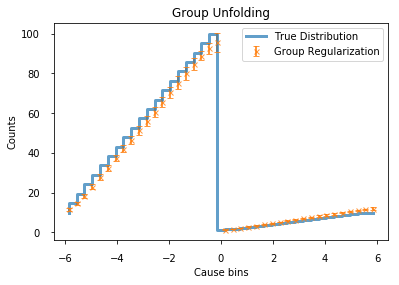

In [40]:
plt.step(bin_midpoints_groups, group_data_true, lw=3,
         alpha=0.7, label='True Distribution')

plt.errorbar(bin_midpoints_groups, unfolded_results_groups_group_reg_prior['unfolded'],
             yerr=unfolded_results_groups_group_reg_prior['sys_err'],
             alpha=0.8,
             elinewidth=2,
             capsize=3,
             ls='None', marker='x', ms=5,
             label='Group Regularization')

plt.title('Group Unfolding')
plt.xlabel('Cause bins')
plt.ylabel('Counts')
plt.legend(loc='best', frameon=True)
plt.show()

Now we're starting to get something that looks right.

However, we are still using two identical copies of the response matrix which means that we're considering the same sets of causes, just split up into two groups.

This also demonstrates another potential issue with doing group unfolding: if there is high degeneracy between the respective response functions, then the unfolding results will be highly dependent on intial priors.

The solution to this is to ensure that the cause group response matrices have different structure, for example by having different normalizations (efficiency). We demonstrate this below to finish.

In [41]:
# Response with two groups having different structures
n_c1 = len(response_hist)
n_c2 = 5
response_hist_groups = np.concatenate((response_hist, response_hist[:,0:n_c2]), axis=1)
response_hist_groups_err = np.sqrt(response_hist_groups)

# Efficiencies with two groups
efficiencies_groups = np.ones(response_hist_groups.shape[1], dtype=float)
efficiencies_groups_err = np.full_like(efficiencies_groups, 0.1, dtype=float)
# Make the second group 25% efficient
efficiencies_groups[0:n_c1] *= 1
efficiencies_groups[n_c1:-1] *= 0.25
efficiencies_groups_err = np.full_like(efficiencies_groups, 0.1, dtype=float)

# Scale by efficiency
column_sums_groups = response_hist_groups.sum(axis=0)
normalization_factor_groups = efficiencies_groups / column_sums_groups

# Response matrix with two groups
response_groups = response_hist_groups * normalization_factor_groups
response_groups_err = response_hist_groups_err * normalization_factor_groups


groups = [0]*n_c1 + [1]*n_c2
print("Group definitions: {}".format(groups))

group_reg = SplineRegularizer(degree=3, smooth=1.25, groups=groups)

Group definitions: [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1]


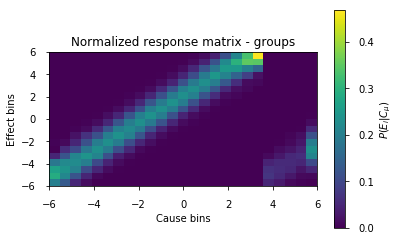

In [42]:
plt.imshow(response_groups,
           origin='lower',
           aspect='0.5',
           extent=[2*bins.min(), 2*bins.max(), 2*bins.min(), 2*bins.max()])
plt.colorbar(label='$P(E_i|C_{\mu})$')
plt.xlabel('Cause bins')
plt.ylabel('Effect bins')
plt.title('Normalized response matrix - groups')
plt.show()

Regenerate some fake data

In [43]:
# True distribution
group_data_true = np.concatenate((np.linspace(10, 100, n_c1), np.linspace(1, 10, n_c2)))
# Observed data, no smearing
group_data_observed = response_groups.dot(group_data_true)
group_data_observed_err = np.sqrt(group_data_observed)

In [44]:
# Flat prior to each group, but one has slightly more preference.
#flat_pref_prior = np.concatenate((1.*np.ones(n_c1), np.ones(n_c2)))
#flat_pref_prior /= flat_pref_prior.sum()

In [45]:
unfolded_results_groups_group_reg = iterative_unfold(data=group_data_observed,
                                                     data_err=group_data_observed_err,
                                                     response=response_groups,
                                                     response_err=response_groups_err,
                                                     efficiencies=efficiencies_groups,
                                                     efficiencies_err=efficiencies_groups_err,
                                                     #prior=flat_pref_prior,
                                                     ts='ks',
                                                     ts_stopping=0.01,
                                                     callbacks=[Logger(), group_reg])

Iteration 1: ts = 0.1481, ts_stopping = 0.01
Iteration 2: ts = 0.0102, ts_stopping = 0.01
Iteration 3: ts = 0.0019, ts_stopping = 0.01


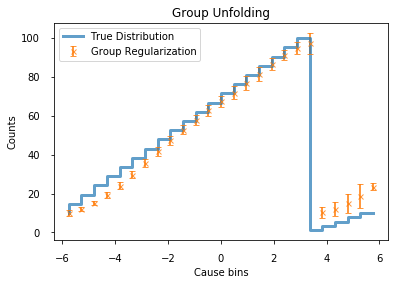

In [46]:
# Extend range of bins
bin_groups = np.linspace(-6, 6, n_c1+n_c2+1)
bin_midpoints_groups = (bin_groups[1:] + bin_groups[:-1]) / 2

plt.step(bin_midpoints_groups, group_data_true, lw=3,
         alpha=0.7, label='True Distribution')

plt.errorbar(bin_midpoints_groups, unfolded_results_groups_group_reg['unfolded'],
             yerr=unfolded_results_groups_group_reg['sys_err'],
             alpha=0.8,
             elinewidth=2,
             capsize=3,
             ls='None', marker='x', ms=5,
             label='Group Regularization')

plt.title('Group Unfolding')
plt.xlabel('Cause bins')
plt.ylabel('Counts')
plt.legend(loc='best', frameon=True)
plt.show()

Since the groups are differentiable in terms of response structure and efficiencies, we obtain reasonable unfolding results even using the default uniform prior across all bins!

This simply illustrates the need for proper understanding of one's data.